# NYT API: updated with Tim's key

In [1]:
from __future__ import division
import pandas
from matplotlib import pyplot as plt 
import seaborn as sns
import requests
import json
import math
import time
import csv
# from textblob import TextBlob
# replace textblob with NLTK (included in Anaconda)
# use NLTK’s build-in Vader Sentiment Analyzer
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/thanniga/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
def grab_data(keyword, start_date, end_date): #"20100101"

    # set key
    key = "23024af0531e446c99d96a8dcfb5cf09"

    # set base url
    base_url = "https://api.nytimes.com/svc/search/v2/articlesearch.json"

    # set search parameters
    search_params = {"q": keyword,
                     "api-key": key,
                     "begin_date": start_date ,  # date must be in YYYYMMDD format
                     "end_date": end_date}

    # make request
    r = requests.get(base_url, params=search_params)

    # wait 3 seconds for the GET request
    time.sleep(3)

    # convert to a dictionary
    data = json.loads(r.text)

    # get number of hits
    hits = data['response']['meta']['hits']
    print("number of hits: ", str(hits))

    # get number of pages
    pages = int(math.ceil(hits / 10))
    print("number of pages: ", str(pages))
    
    data_all = list()
    
    # now we're ready to loop through the pages
    for i in range(pages):
        print("collecting page", str(i))

        # set the page parameter
        search_params['page'] = i

        # make request
        r = requests.get(base_url, params=search_params)

        # get text and convert to a dictionary
        data = json.loads(r.text)
        
        # append dictionary to master list
        data_all.append(data)
        time.sleep(3)  # pause between calls
    filename = '../data/nyt_%s.txt' % keyword
    with open(filename, 'w') as outfile:
        json.dump(data_all, outfile)
    return data_all

In [40]:
def gen_df(data):

    # make an empty dataframe where we'll hold all of our docs for every page
    all_docs = pandas.DataFrame()
    for e in data:
        # get just the docs
        # because some responses are just messages, we need to only gather those with data
        if "response" in e.keys():
            docs = e['response']['docs']
            df_temp = pandas.DataFrame(docs)
            # add those docs to the dataframe
            all_docs = pandas.concat([all_docs, df_temp], ignore_index=True)
    return(all_docs)

In [4]:
def polarity(text):
    sentiment_engine_nltk_vader = SentimentIntensityAnalyzer()
    # vader is one of NLTK's sentiment approaches (we could just simply and leave out that detail)
    score = sentiment_engine_nltk_vader.polarity_scores(text)
    return 1 if score['pos'] > score['neg'] else 0

In [5]:
def clean_data(df):
    df['year'] = df['pub_date'].str[:4]
    df['polarity'] = df['snippet'].apply(polarity)
    grouped = df[['year','_id']].groupby('year').count()
    grouped_text = df[['year', 'polarity']].groupby('year').mean()
    grouped_all = grouped.join(grouped_text)
    grouped_all.rename(columns={'_id': 'count'}, inplace=True)
    return grouped_all

## We start to run the main code here

In [ ]:
data_ev_charging = grab_data("electric vehicle charging", 20050101, 20150101)

In [41]:
df_ev_charging = gen_df(data_ev_charging)

In [42]:
grouped_ev_charging = clean_data(df_ev_charging)

### Inspect the dataframe

In [50]:
grouped_ev_charging

,count,polarity
year,,
2005,8,0.625000
2006,8,0.250000
2007,13,0.538462
2008,22,0.590909
2009,64,0.562500
2010,95,0.631579
2011,97,0.536082
2012,60,0.500000
2013,51,0.372549


### Plot the count column in our dataframe

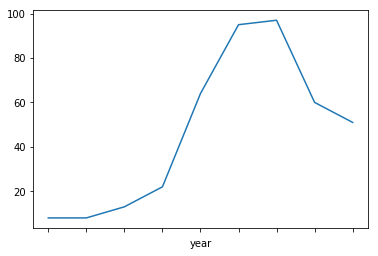

In [48]:
grouped_ev_charging['count'].plot(kind='line')

### Plot the polarity column in our dataframe

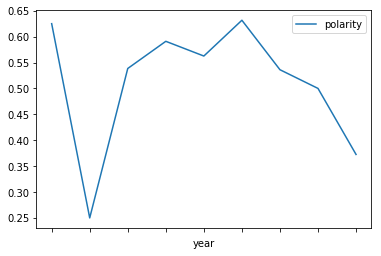

In [45]:
grouped_ev_charging[[ 'polarity']].plot(kind='line')

### Create a table of correlations in our dataframe

In [46]:
grouped_ev_charging.corr()

,count,polarity
count,1.00000,0.28181
polarity,0.28181,1.00000


#### do we want to show the comparison between the two over time? More sentiment after 2010? Before 2010 there were 200 EV charging stations. By 2015 there were 12000 charging stations; there's a reason to believe the sentiment should shift